In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import parc
import scipy.cluster.hierarchy as sch
import matplotlib
from collections import defaultdict
import logging
import pickle
import scipy.sparse
import umap
from skimage import exposure

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path for config
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

# Import path for src
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *
import my_io as io

# Import metadata information

In [5]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

,Pos,Grades,Stage,Directory
0,B1,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1,B3,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2,B5,2,II,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3,C6,AT,AT,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4,D7,3,IIIA,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7


In [6]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [7]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


In [8]:
import skimage
import os 
from skimage import img_as_ubyte
from skimage.transform import rescale

def read_img(ROI: str, data_ROI):
    """Read all image from one ROI"""
    dir_ = data_ROI / ROI

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    img_name = [
        name
        for name in sorted(filenames)
        if "tiff" in name and "ome.tiff" in name and "Cell_Mask" not in name
        and '127' not in name
        and '131Xe' not in name
        and '138Ba' not in name
        and '190BCKG' not in name
        and '191Ir' not in name
        and '193Ir' not in name
        and '208Pb' not in name
        and '152Gd' not in name
    ]
    markers = [name.split("_")[-1].split(".")[0] for name in img_name]
    imgs = np.stack(
        [skimage.io.imread(os.path.join(dirpath, name)) for name in img_name], axis=0
    )
    return imgs, markers

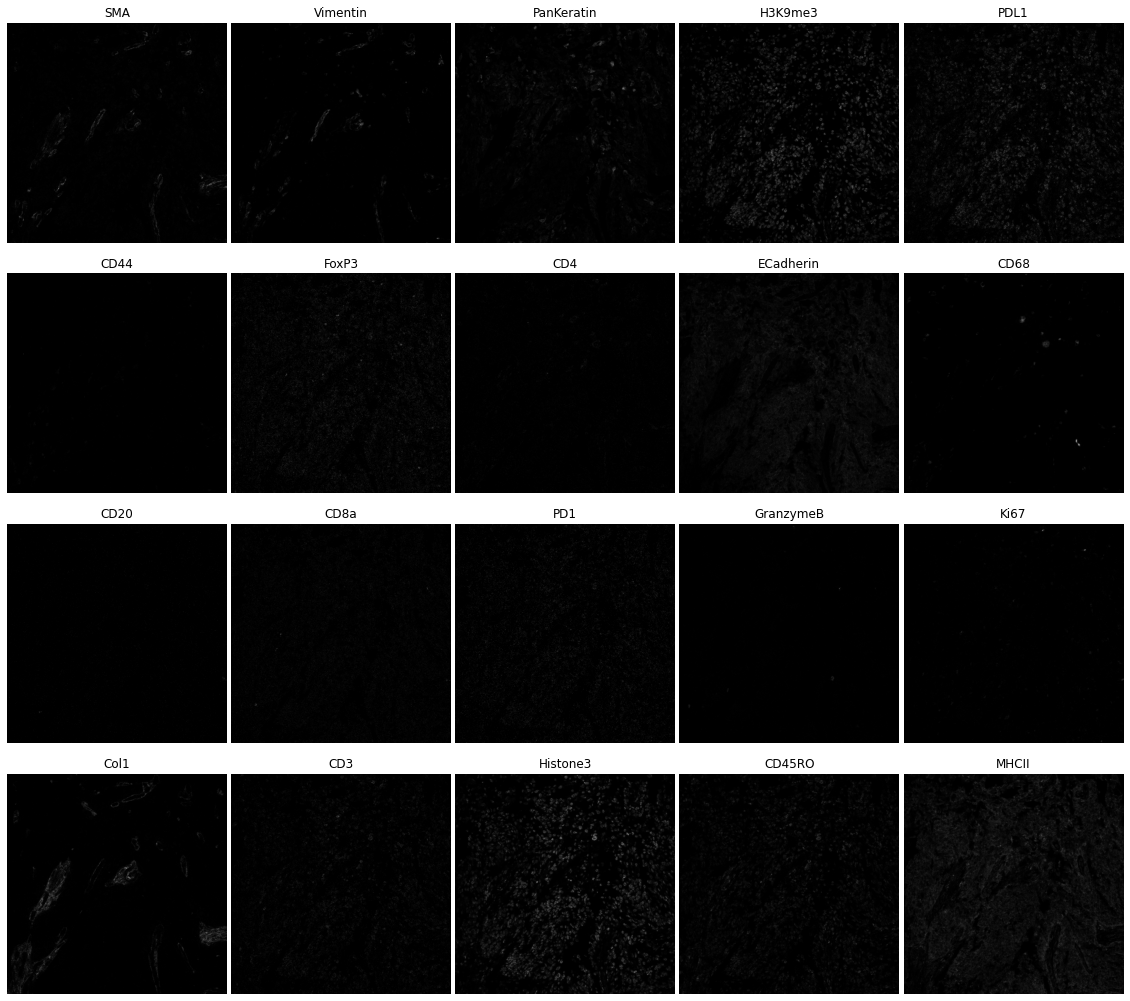

In [9]:
pixels_bright_list = []
scaler = MinMaxScaler()
min_intensity = 0.3

for dataset in datasets:
    # Read images
    imgs, markers = read_img(dataset, data_ROI)
    for i in range(len(markers)):
        if markers[i] == 'H3K4me3':
            markers[i] = 'H3K9me3'
#     for i in range(len(imgs)):
#         img = imgs[i,:,:]
#         p2, p98 = np.percentile(img, (0, 99.9))
#         img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#         imgs[i,:,:] = img_rescale
        
    fig, axs = plt.subplots(4, 5, figsize=(20,18))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if markers[i] not in ['DNA2']:
            ax.imshow(imgs[i], cmap='gray')
            ax.set_title(markers[i])
            ax.axis('off')
    fig.subplots_adjust(wspace=0.02, hspace=0.1)
    plt.show()
    break
#     fig.savefig(data_ex_level / f'{dataset}_th_20_99.png', bbox_inches='tight', dpi=150)

In [10]:
imgs = imgs.reshape(20, -1)
df = pd.DataFrame(imgs, index=markers)
df.index.name = 'Marker'
df.reset_index(inplace=True)
df = df.melt(id_vars = 'Marker', value_name='Intensity')
df['Mean Intensity'] = df.groupby('Marker')['Intensity'].transform('mean')

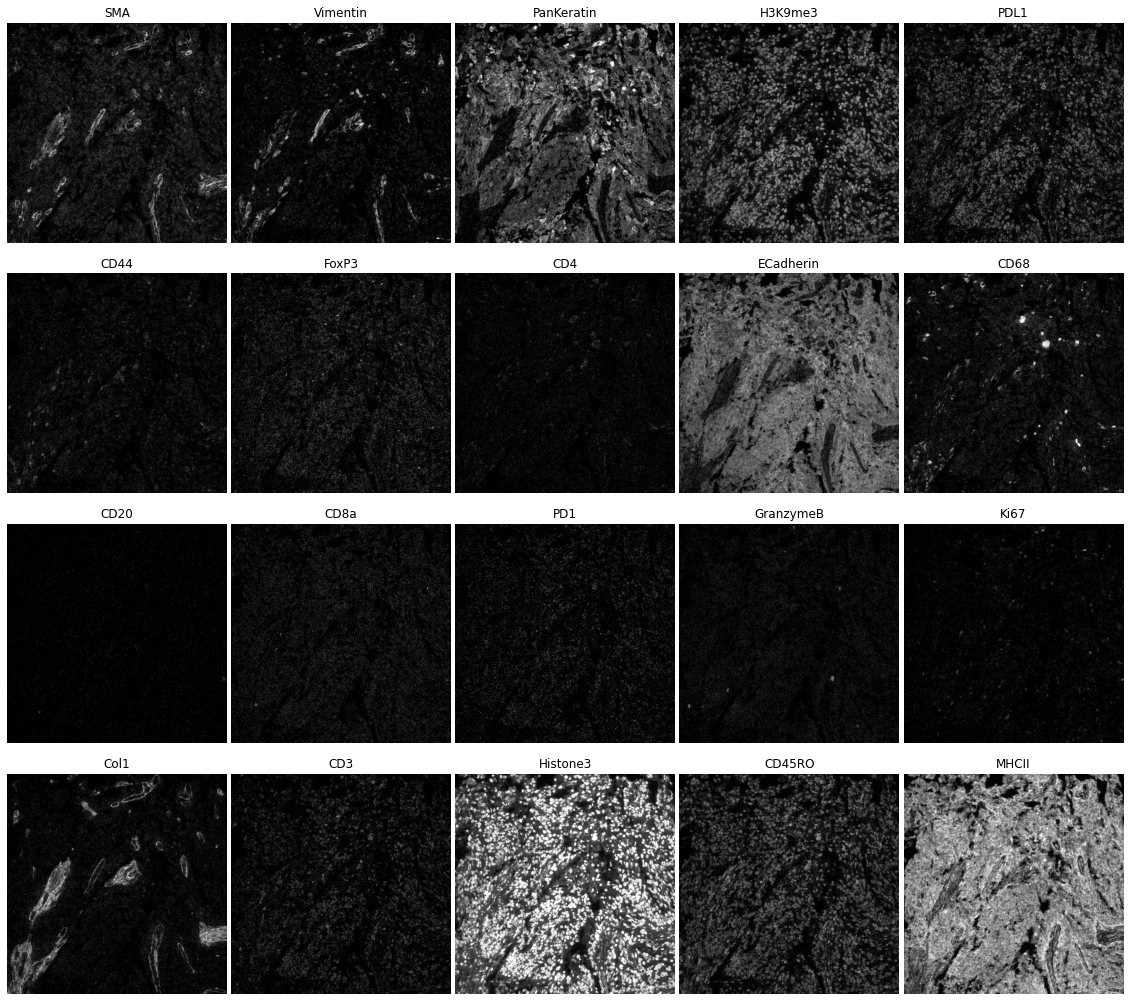

In [11]:
pixels_bright_list = []
scaler = MinMaxScaler()
min_intensity = 0.3

for dataset in datasets:
    # Read images
    imgs, markers = io.read_img(dataset, data_ROI)
#     for i in range(len(imgs)):
#         img = imgs[i,:,:]
#         p2, p98 = np.percentile(img, (0, 99.9))
#         img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#         imgs[i,:,:] = img_rescale
        
    fig, axs = plt.subplots(4, 5, figsize=(20,18))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if markers[i] not in ['DNA2']:
            ax.imshow(imgs[i], cmap='gray')
            ax.set_title(markers[i])
            ax.axis('off')
    fig.subplots_adjust(wspace=0.02, hspace=0.1)
    plt.show()
    break
#     fig.savefig(data_ex_level / f'{dataset}_th_20_99.png', bbox_inches='tight', dpi=150)

In [12]:
imgs = imgs.reshape(22, -1)
df_tiff = pd.DataFrame(imgs, index=markers)
df_tiff.index.name = 'Marker'
df_tiff.reset_index(inplace=True)
df_tiff = df_tiff.melt(id_vars = 'Marker', value_name='Intensity')
df_tiff['Mean Intensity'] = df_tiff.groupby('Marker')['Intensity'].transform('mean')
df_tiff = df_tiff[~df_tiff.Marker.isin(['DNA1', 'DNA2'])]

In [13]:
df['Type'] = 'ome'
df_tiff['Type'] = 'tif'
df_all = pd.concat([df,df_tiff])

In [14]:
df_all = df_all[df_all.Marker != 'Histone3']
df_all = df_all[df_all.Marker != 'MHCII']
df_all = df_all[df_all.Intensity != 0]

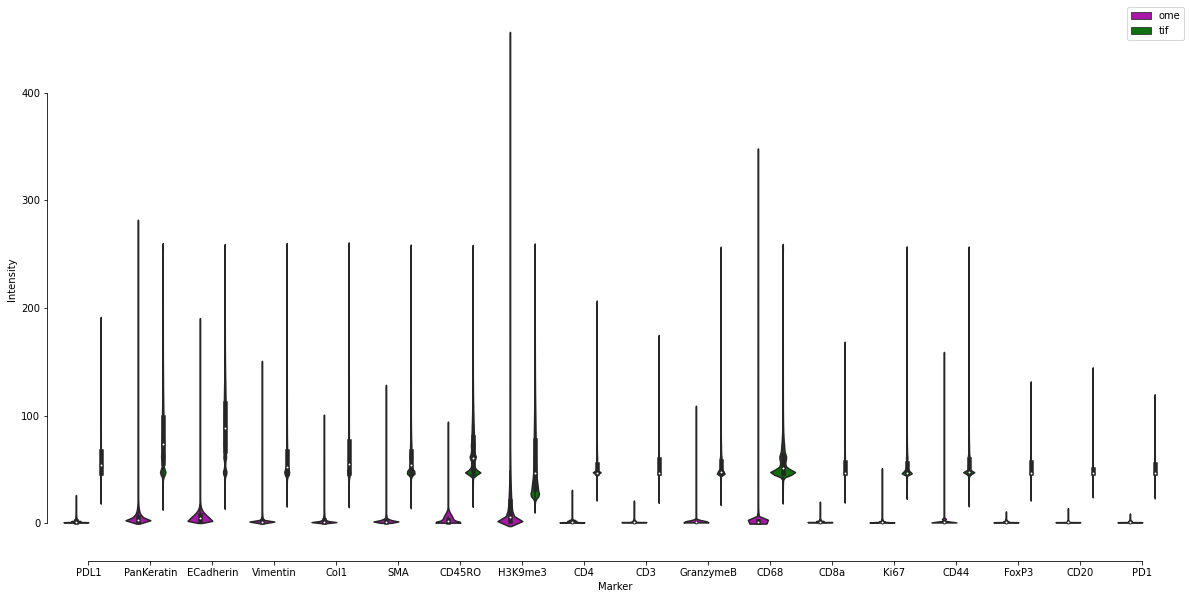

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="Marker", y="Intensity",
            hue="Type", palette=["m", "g"],
            data=df_all, showfliers=False, ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)


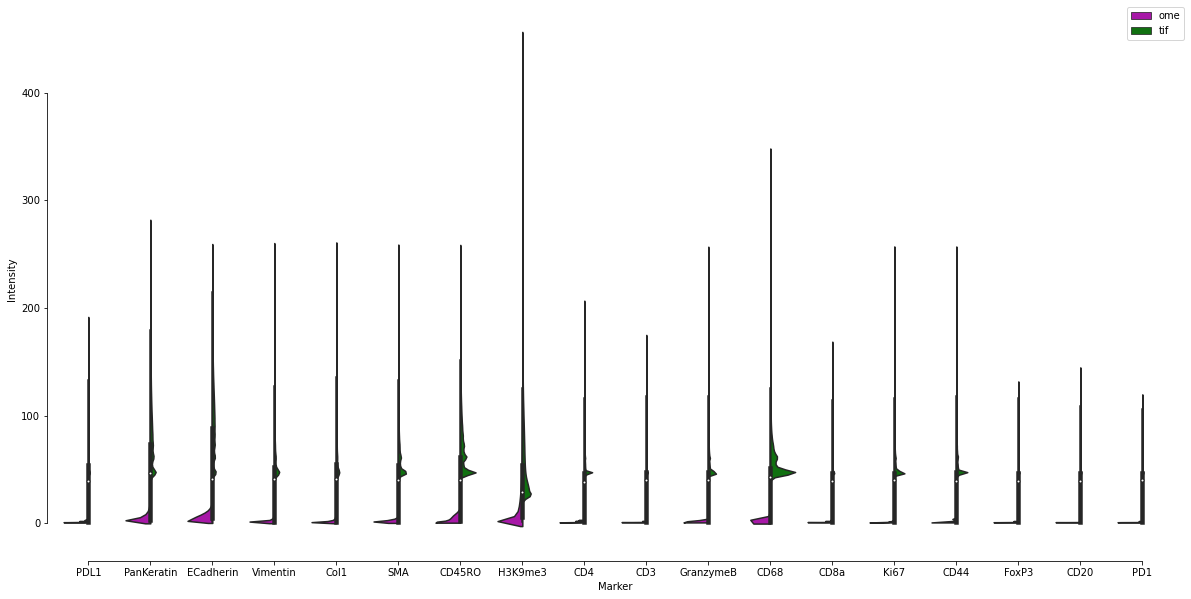

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="Marker", y="Intensity",
            hue="Type", palette=["m", "g"],
            data=df_all, showfliers=False, split=True, ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)


No handles with labels found to put in legend.


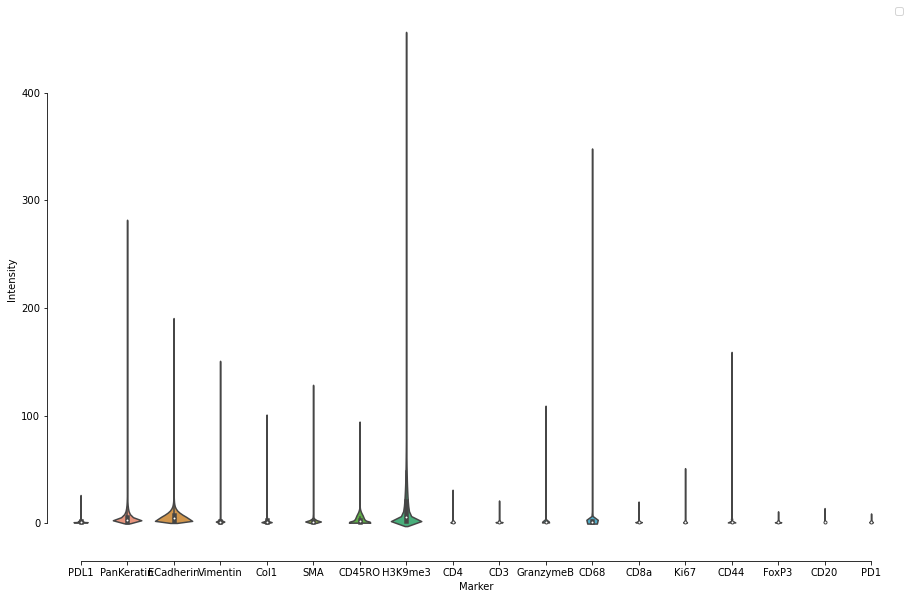

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.violinplot(x="Marker", y="Intensity",
            data=df_all[df_all.Type == 'ome'], showfliers=False, scale='count', ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)



No handles with labels found to put in legend.


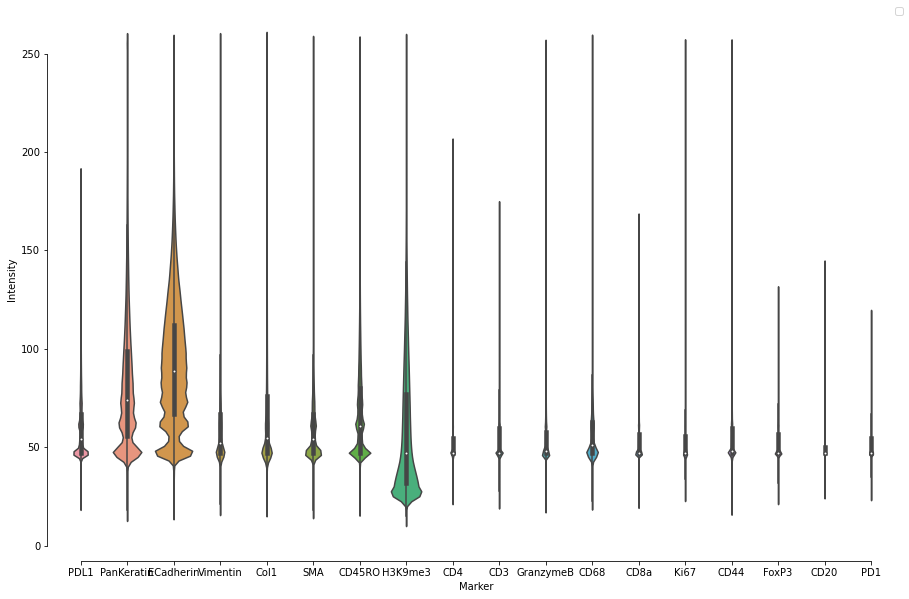

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.violinplot(x="Marker", y="Intensity",
            data=df_all[df_all.Type == 'tif'], showfliers=False, scale='count', ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)



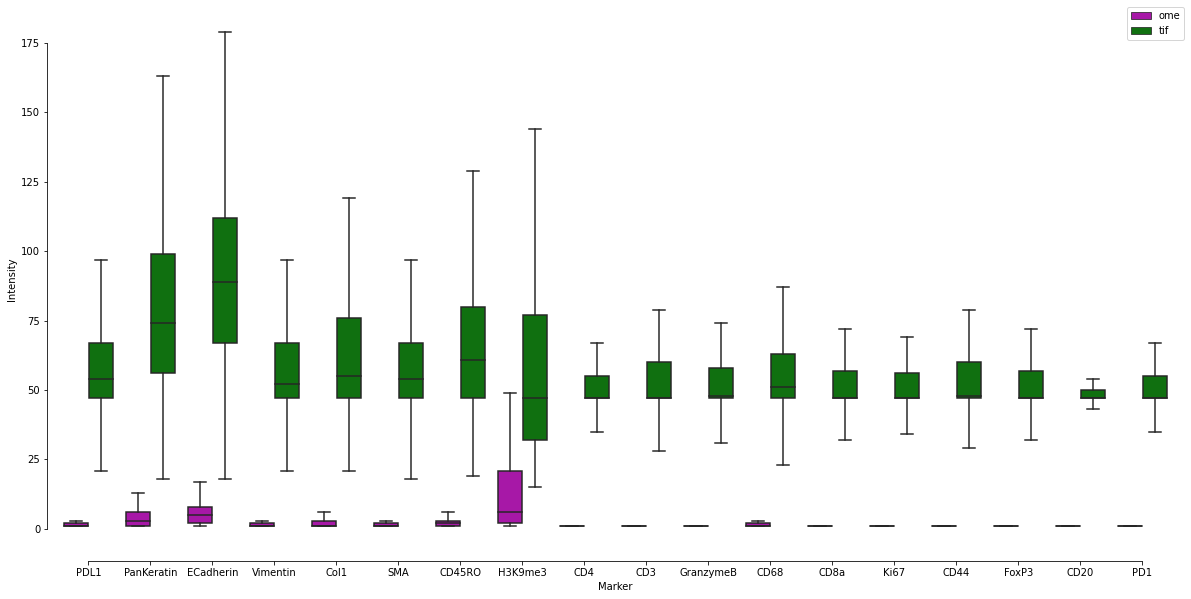

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="Marker", y="Intensity",
            hue="Type", palette=["m", "g"],
            data=df_all, showfliers=False, ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)


No handles with labels found to put in legend.


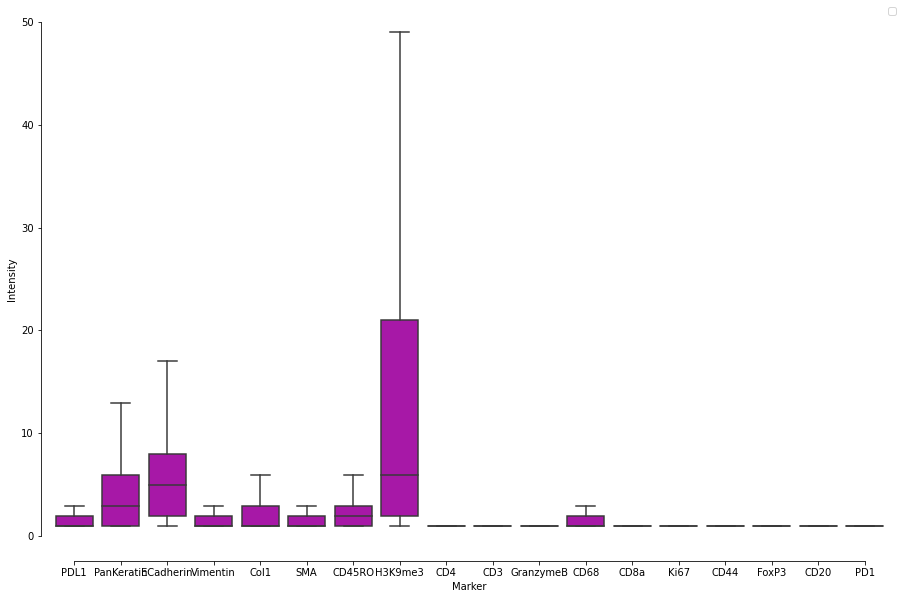

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x="Marker", y="Intensity",
            palette=["m"],
            data=df_all[df_all.Type == 'ome'], showfliers=False, ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)


No handles with labels found to put in legend.


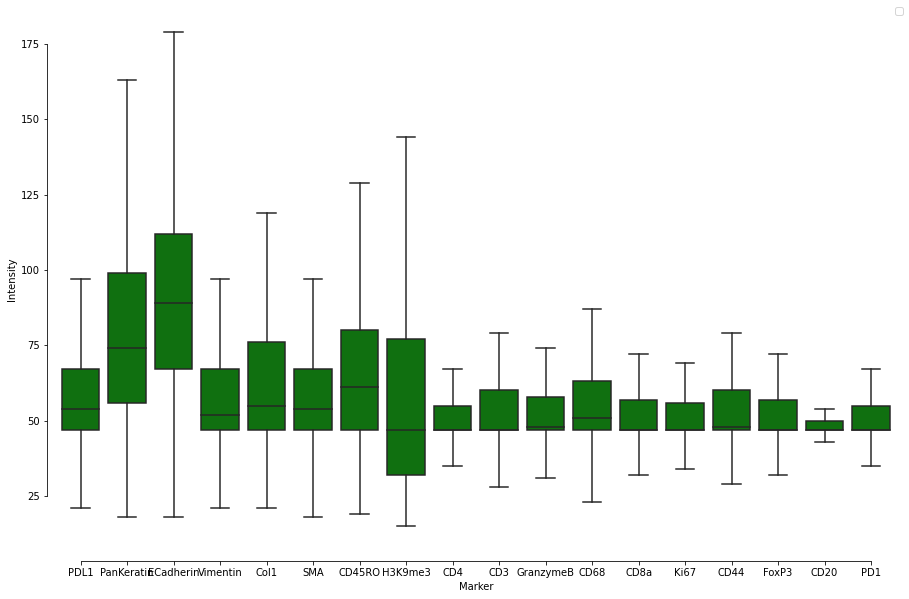

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x="Marker", y="Intensity",
            palette=["g"],
            data=df_all[df_all.Type == 'tif'], showfliers=False, ax = ax)
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)


In [18]:
# num_bins = 50
# for dataset in datasets:
#     # Read images
#     imgs, markers = io.read_img_down(dataset, data_ROI)
#     p2, p98 = np.percentile(imgs, (15, 99.0))
#     for i in range(len(imgs)):
#         img = imgs[i,:,:]
#         img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#         imgs[i,:,:] = img_rescale
#         if markers[i] == 'CD8a':
#             x = imgs[i].flatten()
            
#     fig, ax = plt.subplots(figsize=(10,11))
#     n, bins, patches = ax.hist(x, num_bins)
#     ax.set_title(markers[i])
#     ax.axis('off')